# Calculate surface ocean heat content using CESM2 LENS data

- This notebook is adapted from the NCAR gallery in the Pangeo collection
- https://gallery.pangeo.io/repos/NCAR/notebook-gallery/notebooks/Run-Anywhere/Ocean-Heat-Content/OHC_tutorial.html

### Input Data Access

- This notebook illustrates how to compute surface ocean heat content using potential temperature data from CESM2 Large Ensemble Dataset (https://www.cesm.ucar.edu/community-projects/lens2) hosted on NCAR's glade storage.
- This data is open access and is accessed via OSDF

In [4]:
# Display output of plots directly in Notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import intake
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [5]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 
import cf_units as cf

In [6]:
import dask 
from dask.distributed import Client
from dask.distributed import performance_report

## Setting Dask Schedulers to Use DaskVine

In [7]:
import os

manager_name = api_key = os.environ.get("VINE_MANAGER_NAME")
print(f"Manager name: {manager_name}")

ports_str = os.environ.get("VINE_MANAGER_PORTS", "9123, 9150")
ports = [int(p.strip()) for p in ports_str.split(",")]
print(f"Manager Ports: {ports}")

Manager name: floability-cbf79a46-f8bb-4a0b-a345-ab860804d802
Manager Ports: [502, 510]


In [8]:
vine_run_info_dir = os.environ.get("VINE_RUN_INFO_DIR")
print(f"Vine logs will be saved to {vine_run_info_dir}")

Vine logs will be saved to None


In [9]:
disable_peer_transfer = os.getenv("DISABLE_PEER_TRANSFER", "false").lower() in ("1", "true", "yes")

if disable_peer_transfer:
    print("Peer transfer will be disabled")
else:
    print("Peer transfer will be enabled")

Peer transfer disabled


In [10]:
import ndcctools.taskvine as vine
from functools import partial
import os

m = vine.DaskVine(ports, name=manager_name, run_info_path=vine_run_info_dir)

task_resources = {
    "cores": 1
}

vine_scheduler = partial(m.get, progress_disable=True, resources=task_resources)

dask.config.set(scheduler=vine_scheduler)

## Setting Some Values and Functions

In [11]:
init_year0  = '1991'
init_year1  = '2020'
final_year0 = '2071'
final_year1 = '2100'

In [12]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")

In [13]:
rda_data    = '/tmp/rda'
rda_scratch = '/tmp/rda'
rda_url        =  'https://data.rda.ucar.edu/'

catalog_url = 'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'

## Load CESM LENS2 temperature data

In [14]:
cesm_cat = intake.open_esm_datastore(catalog_url)
cesm_cat

,unique
variable,54
long_name,52
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,4
spatial_domain,3
units,21
start_time,5


In [15]:
cesm_cat.df['variable'].values

<ArrowExtensionArray>
[  'FLNS',  'FLNSC',   'FLUT',   'FSNS',  'FSNSC',  'LHFLX',  'PRECC',
  'PRECL', 'PRECSC', 'PRECSL',
 ...
    'VNS',    'VNT',   'VVEL',    'WTS',    'WTT',   'WVEL',     <NA>,
     <NA>,     <NA>,     <NA>]
Length: 322, dtype: large_string[pyarrow]

In [16]:
cesm_temp = cesm_cat.search(variable ='TEMP', frequency ='monthly')
# cesm_temp = cesm_cat.search(variable ='TREFHTMX', frequency ='daily')

cesm_temp

,unique
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1
start_time,2


In [17]:
cesm_temp.df['path'].values

<ArrowExtensionArray>
['s3://ncar-cesm2-lens/ocn/monthly/cesm2LE-historical-cmip6-TEMP.zarr',
     's3://ncar-cesm2-lens/ocn/monthly/cesm2LE-ssp370-cmip6-TEMP.zarr',
      's3://ncar-cesm2-lens/ocn/monthly/cesm2LE-ssp370-smbb-TEMP.zarr']
Length: 3, dtype: large_string[pyarrow]

In [18]:
print(list(cesm_temp.keys()))

['ocn.historical.monthly.cmip6', 'ocn.ssp370.monthly.cmip6', 'ocn.ssp370.monthly.smbb']


In [19]:
dsets_cesm = cesm_temp.to_dataset_dict(storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


In [20]:
# disable peer trasnfer after data download steps
if disable_peer_transfer:
    m.disable_peer_transfers()
    print("Peer transfer disabled")

1

In [21]:
cesm_temp.keys()

['ocn.historical.monthly.cmip6',
 'ocn.ssp370.monthly.cmip6',
 'ocn.ssp370.monthly.smbb']

In [22]:
# cesm_temp.keys()

In [23]:
historical       = dsets_cesm['ocn.historical.monthly.cmip6']
future_smbb      = dsets_cesm['ocn.ssp370.monthly.smbb']
future_cmip6     = dsets_cesm['ocn.ssp370.monthly.cmip6']

In [24]:
# %%time
# merge_ds_cmip6 = xr.concat([historical, future_cmip6], dim='time')
# merge_ds_cmip6 = merge_ds_cmip6.dropna(dim='member_id')

In [25]:
historical

<xarray.Dataset> Size: 3TB
Dimensions:     (member_id: 50, time: 1980, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time        (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bound  (time, d2) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * z_t         (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (member_id, time, z_t, nlat, nlon) float32 3TB dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    revision:                          $Id$
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1850-01-16 12:00:00
    intake_esm_attrs:end_time:         2014-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm2-lens/ocn/monthly/cesm2...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.historical.monthly.cmip6

#### Change units

In [26]:
orig_units = cf.Unit(historical.z_t.attrs['units'])
orig_units

Unit('centimeters')

In [27]:
def change_units(ds, variable_str, variable_bounds_str, target_unit_str):
    orig_units = cf.Unit(ds[variable_str].attrs['units'])
    target_units = cf.Unit(target_unit_str)
    variable_in_new_units = xr.apply_ufunc(orig_units.convert, ds[variable_bounds_str], target_units, dask='parallelized', output_dtypes=[ds[variable_bounds_str].dtype])
    return variable_in_new_units

In [28]:
historical['z_t']

<xarray.DataArray 'z_t' (z_t: 60)> Size: 240B
array([5.000000e+02, 1.500000e+03, 2.500000e+03, 3.500000e+03, 4.500000e+03,
       5.500000e+03, 6.500000e+03, 7.500000e+03, 8.500000e+03, 9.500000e+03,
       1.050000e+04, 1.150000e+04, 1.250000e+04, 1.350000e+04, 1.450000e+04,
       1.550000e+04, 1.650984e+04, 1.754790e+04, 1.862913e+04, 1.976603e+04,
       2.097114e+04, 2.225783e+04, 2.364088e+04, 2.513702e+04, 2.676542e+04,
       2.854837e+04, 3.051192e+04, 3.268680e+04, 3.510935e+04, 3.782276e+04,
       4.087846e+04, 4.433777e+04, 4.827367e+04, 5.277280e+04, 5.793729e+04,
       6.388626e+04, 7.075633e+04, 7.870025e+04, 8.788252e+04, 9.847059e+04,
       1.106204e+05, 1.244567e+05, 1.400497e+05, 1.573946e+05, 1.764003e+05,
       1.968944e+05, 2.186457e+05, 2.413972e+05, 2.649001e+05, 2.889385e+05,
       3.133405e+05, 3.379793e+05, 3.627670e+05, 3.876452e+05, 4.125768e+05,
       4.375392e+05, 4.625190e+05, 4.875083e+05, 5.125028e+05, 5.375000e+05],
      dtype=float32)
Coordinates:
  * z_t      (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Attributes:
    long_name:  depth from surface to midpoint of layer
    positive:   down
    units:      centimeters
    valid_max:  537500.0
    valid_min:  500.0

In [29]:
depth_levels_in_m = change_units(historical, 'z_t', 'z_t', 'm')
hist_temp_in_degK = change_units(historical, 'TEMP', 'TEMP', 'degK')
fut_cmip6_temp_in_degK = change_units(future_cmip6, 'TEMP', 'TEMP', 'degK')
fut_smbb_temp_in_degK = change_units(future_smbb, 'TEMP', 'TEMP', 'degK')
#
hist_temp_in_degK  = hist_temp_in_degK.assign_coords(z_t=("z_t", depth_levels_in_m['z_t'].data))
hist_temp_in_degK["z_t"].attrs["units"] = "m"
hist_temp_in_degK

<xarray.DataArray (member_id: 50, time: 1980, z_t: 60, nlat: 384, nlon: 320)> Size: 3TB
dask.array<transpose, shape=(50, 1980, 60, 384, 320), dtype=float32, chunksize=(1, 6, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * z_t        (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon

In [30]:
depth_levels_in_m.isel(z_t=slice(0, -1))

<xarray.DataArray (z_t: 59)> Size: 236B
array([5.0000000e+00, 1.5000000e+01, 2.5000000e+01, 3.5000000e+01,
       4.5000000e+01, 5.5000000e+01, 6.5000000e+01, 7.5000000e+01,
       8.5000000e+01, 9.5000000e+01, 1.0500000e+02, 1.1500000e+02,
       1.2500000e+02, 1.3500000e+02, 1.4500000e+02, 1.5500000e+02,
       1.6509840e+02, 1.7547905e+02, 1.8629128e+02, 1.9766028e+02,
       2.0971138e+02, 2.2257828e+02, 2.3640883e+02, 2.5137016e+02,
       2.6765421e+02, 2.8548364e+02, 3.0511923e+02, 3.2686798e+02,
       3.5109348e+02, 3.7822763e+02, 4.0878464e+02, 4.4337769e+02,
       4.8273672e+02, 5.2772803e+02, 5.7937286e+02, 6.3886261e+02,
       7.0756329e+02, 7.8700250e+02, 8.7882526e+02, 9.8470587e+02,
       1.1062042e+03, 1.2445669e+03, 1.4004972e+03, 1.5739464e+03,
       1.7640033e+03, 1.9689442e+03, 2.1864565e+03, 2.4139717e+03,
       2.6490012e+03, 2.8893848e+03, 3.1334048e+03, 3.3797935e+03,
       3.6276704e+03, 3.8764519e+03, 4.1257681e+03, 4.3753926e+03,
       4.6251904e+03, 4.8750835e+03, 5.1250283e+03], dtype=float32)
Coordinates:
  * z_t      (z_t) float32 236B 500.0 1.5e+03 2.5e+03 ... 4.875e+05 5.125e+05

In [31]:
#Compute depth level deltas using z_t levels
depth_level_deltas = depth_levels_in_m.isel(z_t=slice(1, None)).values - depth_levels_in_m.isel(z_t=slice(0, -1)).values
# Optionally, if you want to keep it as an xarray DataArray, re-wrap the result
depth_level_deltas = xr.DataArray(depth_level_deltas, dims=["z_t"], coords={"z_t": depth_levels_in_m.z_t.isel(z_t=slice(0, -1))})
depth_level_deltas                                                                                        

<xarray.DataArray (z_t: 59)> Size: 236B
array([ 10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.098404,  10.380646,  10.812225,  11.369003,  12.051102,
        12.866898,  13.830551,  14.961334,  16.284042,  17.829437,
        19.63559 ,  21.748749,  24.225494,  27.134155,  30.557007,
        34.59305 ,  39.35904 ,  44.991302,  51.644836,  59.489746,
        68.70068 ,  79.43921 ,  91.822754, 105.880615, 121.49835 ,
       138.36267 , 155.9303  , 173.44922 , 190.05688 , 204.94092 ,
       217.51233 , 227.51514 , 235.02954 , 240.38354 , 244.02002 ,
       246.38867 , 247.87695 , 248.7815  , 249.31616 , 249.62451 ,
       249.79785 , 249.89307 , 249.94482 , 249.97168 ], dtype=float32)
Coordinates:
  * z_t      (z_t) float32 236B 500.0 1.5e+03 2.5e+03 ... 4.875e+05 5.125e+05

# Compute Ocean Heat content for ocean surface
- Ocean surface is considered to be the top 100m
- The formula for this is: $$ H = \rho C \int_0^z T(z) dz $$


Where H is ocean heat content, the value we are trying to calculate,

$\rho$ is the density of sea water, $1026 kg/m^3$  ,

$C$ is the specific heat of sea water, $3990 J/(kg K)$  ,

$z$ is the depth limit of the calculation in meters,

and $T(z)$ is the temperature at each depth in degrees Kelvin.

In [32]:
def calc_ocean_heat(delta_level, temperature):
    rho = 1026 #kg/m^3
    c_p = 3990 #J/(kg K)
    weighted_temperature = delta_level * temperature
    heat = weighted_temperature.sum(dim="z_t")*rho*c_p
    return heat

In [33]:
# Remember that the coordinate z_t still has values in cm
hist_temp_ocean_surface = hist_temp_in_degK.where(hist_temp_in_degK['z_t'] < 1e4,drop=True)
hist_temp_ocean_surface

<xarray.DataArray (member_id: 50, time: 1980, z_t: 10, nlat: 384, nlon: 320)> Size: 487GB
dask.array<where, shape=(50, 1980, 10, 384, 320), dtype=float32, chunksize=(1, 6, 10, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * z_t        (z_t) float32 40B 500.0 1.5e+03 2.5e+03 ... 8.5e+03 9.5e+03
Dimensions without coordinates: nlat, nlon

In [34]:
depth_level_deltas_surface = depth_level_deltas.where(depth_level_deltas['z_t'] <1e4, drop= True)
depth_level_deltas_surface

<xarray.DataArray (z_t: 10)> Size: 40B
array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.], dtype=float32)
Coordinates:
  * z_t      (z_t) float32 40B 500.0 1.5e+03 2.5e+03 ... 7.5e+03 8.5e+03 9.5e+03

In [35]:
hist_ocean_heat = calc_ocean_heat(depth_level_deltas_surface,hist_temp_ocean_surface)
hist_ocean_heat

<xarray.DataArray (member_id: 50, time: 1980, nlat: 384, nlon: 320)> Size: 49GB
dask.array<mul, shape=(50, 1980, 384, 320), dtype=float32, chunksize=(1, 6, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: nlat, nlon

### Plot Ocean Heat

In [36]:
%%time
# Jan, 1850 average over all memebers
# hist_ocean_avgheat = hist_ocean_heat.mean('member_id')
hist_ocean_avgheat = hist_ocean_heat.isel({'time':[0,-12]}).mean('member_id')
hist_ocean_avgheat

CPU times: user 8.66 ms, sys: 79 μs, total: 8.74 ms
Wall time: 8.48 ms


<xarray.DataArray (time: 2, nlat: 384, nlon: 320)> Size: 983kB
dask.array<mean_agg-aggregate, shape=(2, 384, 320), dtype=float32, chunksize=(2, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 16B 1850-01-16 12:00:00 2014-01-16 12:00:00
Dimensions without coordinates: nlat, nlon

CPU times: user 2.22 s, sys: 31.4 s, total: 33.6 s
Wall time: 13min 20s


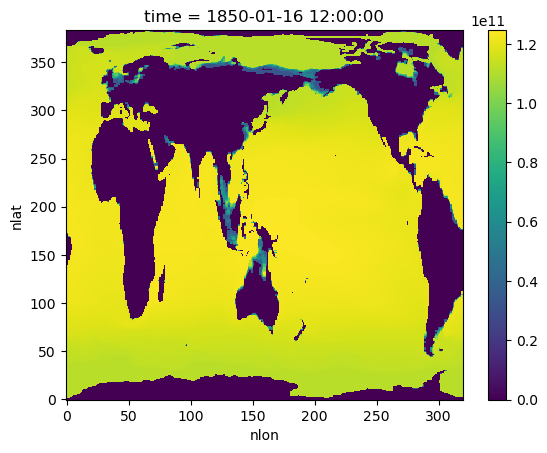

In [37]:
%%time
hist_ocean_avgheat.isel(time=0).plot()

CPU times: user 2 s, sys: 29.9 s, total: 31.9 s
Wall time: 11min 29s


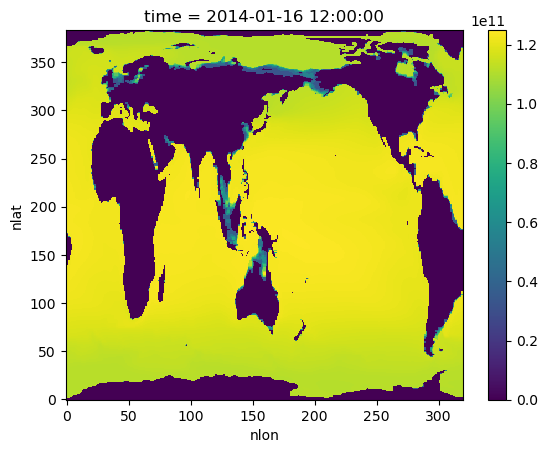

In [38]:
%%time
#Plot ocean heat for Jan 2014
hist_ocean_avgheat.isel(time=1).plot()

### Has the surface ocean heat content increased with time for January ? (Due to Global Warming!)

In [39]:
hist_ocean_avgheat_ano = hist_ocean_avgheat.isel(time=1) - hist_ocean_avgheat.isel(time=0)

In [ ]:
%%time
hist_ocean_avgheat_ano.plot()